In [1]:
import cv2
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def loadFromUrl(image_url):
    # URL of the image
#     image_url = 'https://t3.ftcdn.net/jpg/02/43/12/34/360_F_243123463_zTooub557xEWABDLk0jJklDyLSGl2jrr.jpg'

    # Step 1: Get the image from the URL using requests
    response = requests.get(image_url)

    # Step 2: Convert the content of the response to a NumPy array (binary data)
    image_array = np.array(bytearray(response.content), dtype=np.uint8)

    # Step 3: Decode the image into a format OpenCV understands
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Step 4: Display the image (optional)
    plt.imshow(image)
    plt.show()
    return image

In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
import timeit
import random

# Load the pre-trained Faster R-CNN model
faster_rcnn_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()

# Load the YOLOv8 model
yolo_model = YOLO('yolov8n.pt')  # You can use 'yolov8s.pt', 'yolov8m.pt', etc.

# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor()  # Convert the image to a tensor
])

def compareDetectionFastRCNNandYolov8(img):
    image = 0
    if (str(img).__contains__('http')):
        image = loadFromUrl(img)
    else:
        # Load and preprocess the image
        image = Image.open(img).convert("RGB")
    image_path = img
    image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

    start_time = timeit.default_timer()
    # Run Faster R-CNN object detection
    with torch.no_grad():
        faster_rcnn_predictions = faster_rcnn_model(image_tensor)
    end_time = timeit.default_timer()
    fastRCNN_predict_time = end_time - start_time

    start_time = timeit.default_timer()
    # Run YOLOv8 object detection
    yolo_results = yolo_model(image)
    end_time = timeit.default_timer()
    yolov8_predict_time = end_time - start_time

    # Get the Faster R-CNN prediction results
    rcnn_boxes = faster_rcnn_predictions[0]['boxes']
    rcnn_labels = faster_rcnn_predictions[0]['labels']
    rcnn_scores = faster_rcnn_predictions[0]['scores']

    # Load COCO labels (91 classes)
    COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
        'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
        'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
        'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

    color = {}
    for name in COCO_INSTANCE_CATEGORY_NAMES:
        color[name] = random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Faster R-CNN Visualization
    ax1.imshow(image)
    ax1.set_title('Faster R-CNN Results')

    number_object_detected = 0
    for i, box in enumerate(rcnn_boxes):
        score = rcnn_scores[i].item()
        if score > 0.7:  # Confidence threshold
            number_object_detected += 1
            x_min, y_min, x_max, y_max = box
            label = COCO_INSTANCE_CATEGORY_NAMES[rcnn_labels[i]]

            # Draw the bounding box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=1, edgecolor=color[label], facecolor='none')
            ax1.add_patch(rect)

            # Add the label
            ax1.text(x_min, y_min, f'{label}: {score:.2f}', color=color[label],
                     fontsize=16)
    print("Faster R-CNN detected {} objects in {} miliseconds!".format(number_object_detected, fastRCNN_predict_time))
    ax1.axis('off')

    # YOLOv8 Visualization
    ax2.imshow(image)
    ax2.set_title('YOLOv8 Results')

    number_object_detected = 0
    for result in yolo_results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes
        scores = result.boxes.conf.cpu().numpy()  # Confidence scores
        labels = result.boxes.cls.cpu().numpy().astype(int)  # Class labels
        class_names = result.names  # Class names dictionary

        for i, box in enumerate(boxes):
            score = scores[i]
            if score > 0.7:  # Confidence threshold
                number_object_detected += 1
                x_min, y_min, x_max, y_max = box
                label = class_names[labels[i]]

                # Draw the bounding box
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                         linewidth=1, edgecolor=color[label], facecolor='none')
                ax2.add_patch(rect)

                # Add the label
                ax2.text(x_min, y_min, f'{label}: {score:.2f}', color=color[label],
                         fontsize=16)

    ax2.axis('off')
    print("Yolov8 detected {} objects {} miliseconds!".format(number_object_detected,yolov8_predict_time ))
    plt.tight_layout()
    plt.show()


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\ASUS\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\fasterrcnn_resnet5

100%|██████████| 6.25M/6.25M [00:01<00:00, 6.53MB/s]


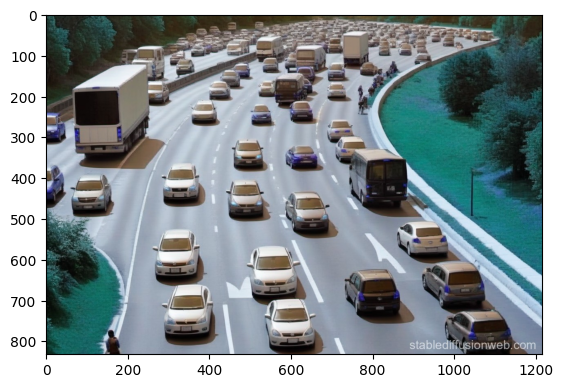


0: 448x640 1 person, 36 cars, 4 buss, 3 trucks, 144.1ms
Speed: 5.0ms preprocess, 144.1ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)
Faster R-CNN detected 36 objects in 3.5688060999964364 miliseconds!
Yolov8 detected 16 objects 1.939064000005601 miliseconds!


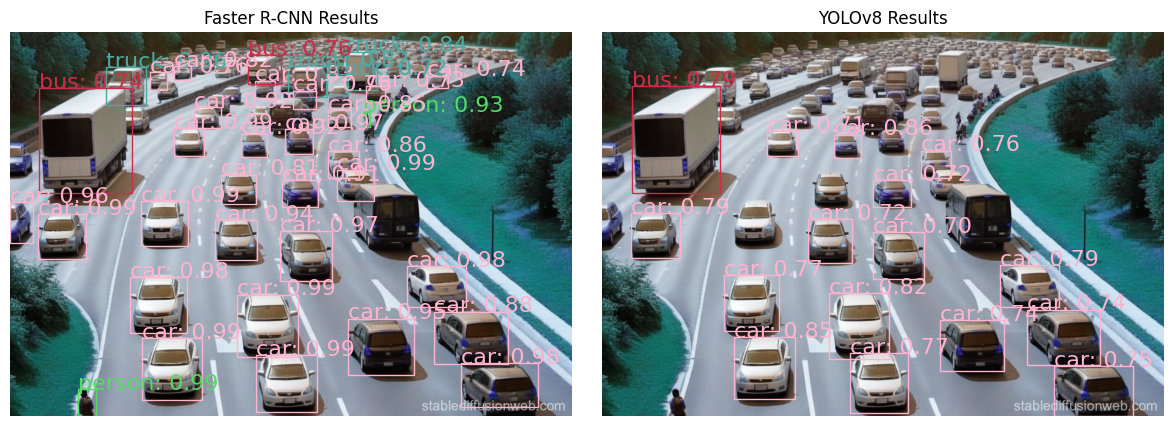

In [3]:
compareDetectionFastRCNNandYolov8('https://imgcdn.stablediffusionweb.com/2024/3/16/7ff420cf-f2d2-4c1b-b47d-511510d1476e.jpg')

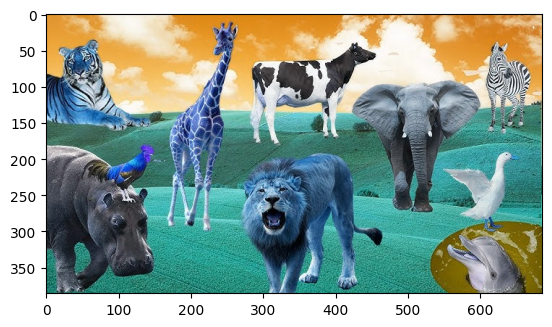


0: 384x640 1 bird, 2 dogs, 1 cow, 1 elephant, 1 zebra, 2 giraffes, 91.3ms
Speed: 2.0ms preprocess, 91.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Faster R-CNN detected 7 objects in 3.274206200003391 miliseconds!
Yolov8 detected 5 objects 0.09934290000819601 miliseconds!


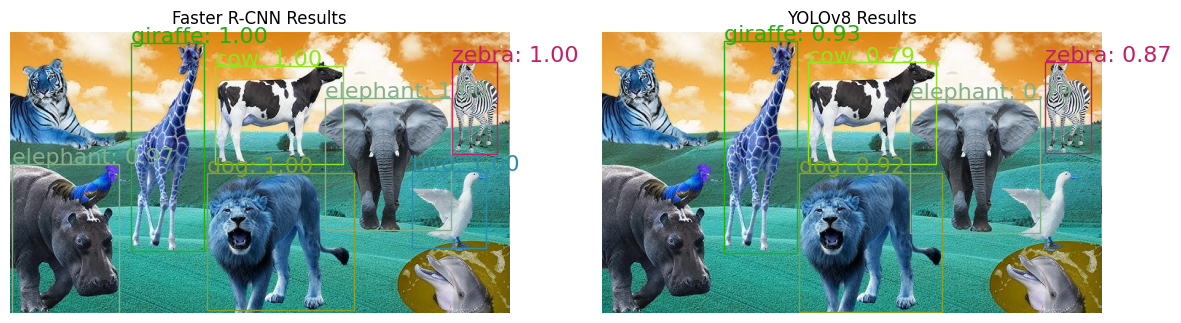

In [4]:
compareDetectionFastRCNNandYolov8('https://i.ytimg.com/vi/Meu9L5fQGG8/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLCufB7ka92vEyas05SgiSpzJVc3mg')

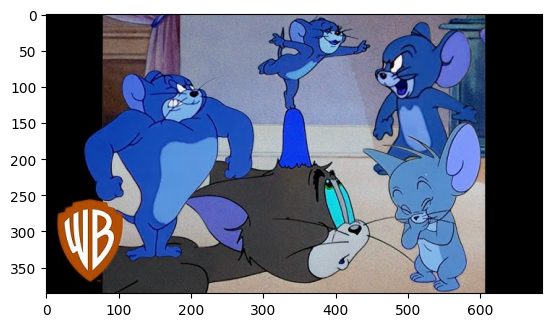


0: 384x640 (no detections), 128.2ms
Speed: 4.0ms preprocess, 128.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Faster R-CNN detected 0 objects in 3.4983369999972638 miliseconds!
Yolov8 detected 0 objects 0.13876430000527762 miliseconds!


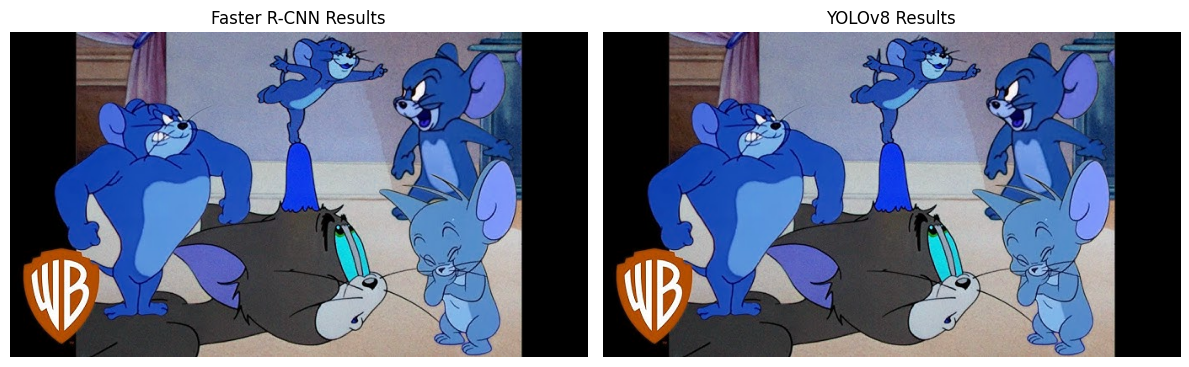

In [5]:
compareDetectionFastRCNNandYolov8('https://i.ytimg.com/vi/Si7DovGBDuQ/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLD-SqSM9_mpf9hOBjYZS3FdDRocWA')

In [7]:
import glob
images_to_test = glob.glob("/kaggle/input/human-dataset/images/val/*.jpg")
print(len(images_to_test))

for img in images_to_test[0:10]:
    compareDetectionFastRCNNandYolov8(img)

0
